In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix


from sklearn.feature_extraction.text import TfidfVectorizer

# IMDB Review Sentiment

#### dataset explore

In [1]:
# this will basically be an easier version because all features come directly from tfidf

In [3]:
df = pd.read_csv("../../datasets/IMDB Dataset.csv")
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


<Axes: ylabel='count'>

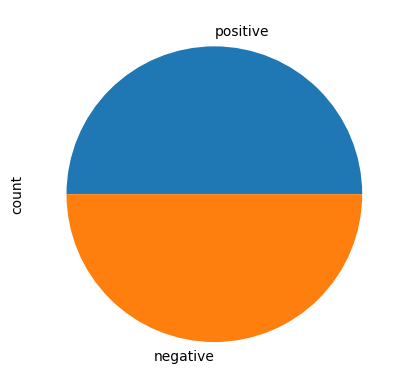

In [6]:
df.sentiment.value_counts().plot(kind="pie")

#### feature eng

In [19]:
v = TfidfVectorizer()
x = v.fit_transform(df['review'])
x

<50000x101895 sparse matrix of type '<class 'numpy.float64'>'
	with 6826529 stored elements in Compressed Sparse Row format>

In [7]:
y = df['sentiment'].map({"positive":1,"negative":0})

In [21]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [22]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((40000, 101895), (40000,), (10000, 101895), (10000,))

In [23]:
X_train[0], y_train[0]

(<1x101895 sparse matrix of type '<class 'numpy.float64'>'
 	with 258 stored elements in Compressed Sparse Row format>,
 1)

#### LR

In [24]:
clf = LogisticRegression()
scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1')
print(scores)

[0.89628807 0.89465194 0.89654318 0.89262162 0.89123417]


In [25]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

<Axes: >

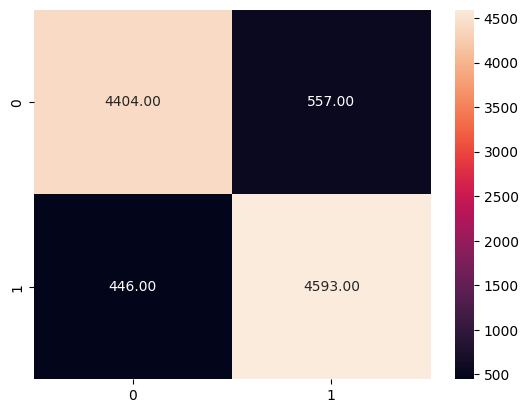

In [28]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt=".2f")

#### RF

In [29]:
rf_grid = RandomForestClassifier()
gr_space = {
    'max_depth': [3,5,7,10],
    'n_estimators': [100, 200],
    'max_features': [10, 20, 30],
    'min_samples_leaf': [1, 2, 4]
}

grid = GridSearchCV(rf_grid, gr_space, cv = 3, scoring='accuracy', verbose = 1)
model_grid = grid.fit(X_train, y_train)

print('Best hyperparameters are '+str(model_grid.best_params_))
print('Best score is: ' + str(model_grid.best_score_))

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best hyperparameters are {'max_depth': 10, 'max_features': 30, 'min_samples_leaf': 4, 'n_estimators': 200}
Best score is: 0.7903997284947873


<Axes: >

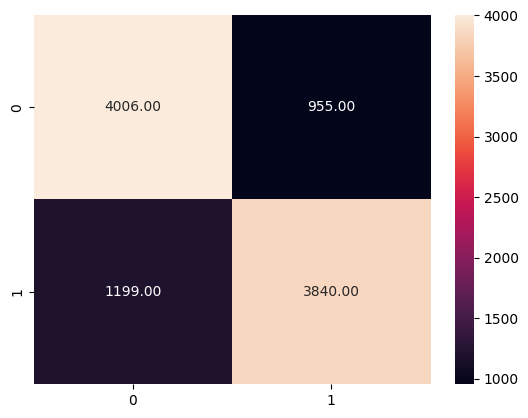

In [33]:
sns.heatmap(confusion_matrix(y_test,model_grid.predict(X_test)), annot=True, fmt=".2f")

#### cnn

In [1]:
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

In [40]:
x.shape[0], x.shape[1]

(50000, 101895)

In [4]:
# Config
vocab_size = 1000
maxlen = 100

# Tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df["review"])
sequences = tokenizer.texts_to_sequences(df["review"])
padded = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')

In [5]:
num_classes = 2

In [6]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=maxlen),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # For multiclass
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.fit(padded, y, epochs=3, batch_size=16, validation_split=0.2)

Epoch 1/3
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - accuracy: 0.8767 - loss: 0.2908 - val_accuracy: 0.7967 - val_loss: 0.4579
Epoch 2/3
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 48s 19ms/step - accuracy: 0.9165 - loss: 0.2098 - val_accuracy: 0.8039 - val_loss: 0.4694
Epoch 3/3
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 39s 16ms/step - accuracy: 0.9465 - loss: 0.1413 - val_accuracy: 0.8009 - val_loss: 0.6323
